<a href="https://colab.research.google.com/github/divyansh351/ML-Bootcamp-WOC/blob/main/EMNISTClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression (One vs All)**
Dectecting handwritten letters from the Extended-MNIST dataset

### **Importing necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import scipy.optimize as op  #used to optimize the theta by the fmincg function discussed in the Andrew NG's course

### **Defining Functions**

**Sigmoid function -** The Hypothesis function for logistic regression

In [ ]:
def sigmoid(z):
  return 1.0/(1 + np.exp(-z))

**Prediction Function -** sigmoid(z), where z=(theta)T*X

Also adding a set of bias features.

In [ ]:
def predictOneVsAll(all_theta, X):
  m = X.shape[0]
  #Add ones (bias feature) to the X data matrix along the second axis (columns).
  X = np.c_[np.ones((m, 1)), X]
  predictions = sigmoid(np.dot(X, all_theta.T))
  
  return np.argmax(predictions, axis=1)
  #Returns the indices of the maximum value of the prediction function for the one vs all classifier.
  #the index corresponds to the letter, 1-25 for A to Y and 0 for Z.

**Logistic Regression Gradient Function -** (With Regularization), Vectorized form

In [ ]:
def lrGradient(theta, X, y, reg_lambda, flattenResult=True):
  m, n = X.shape  
  theta = theta.reshape((n, 1))
  prediction = sigmoid(np.dot(X, theta))
  errors = np.subtract(prediction, y)
  grad = (1.0/m) * np.dot(X.T, errors)

  grad_with_regul = grad[1:] + (reg_lambda/m) * theta[1:]
  firstRow = grad[0, :].reshape((1,1))
  grad = np.r_[firstRow, grad_with_regul]
  
  if  flattenResult:    
    return grad.flatten()
  
  return grad

**One Vs All Optimization Function -** Same as the fmincg function in the Andrew NG course (Reference: Internet)

In [ ]:
def oneVsAll(X, y, num_labels, reg_lambda):
  m, n = X.shape
  #Defining theta matrix initially with size including the bias feature.
  all_theta = np.zeros((num_labels, n + 1))
  #Add ones (bias feature) to the X data matrix along the second axis (columns).
  X = np.c_[np.ones((m, 1)), X]
  
  for c in range(num_labels):
    print("Optimizing theta ", c)
    #Setting Initial theta
    initial_theta = np.zeros((n + 1, 1))
            
    # Run fmincg to obtain the optimal theta
    Result = op.minimize(fun = lrCostFunction, x0 = initial_theta, args = (X, (y == c) * 1, reg_lambda), method = 'TNC', jac = lrGradient, options={'maxiter' : 45})
    optimal_theta = Result.x
    all_theta[c,:] =  optimal_theta
      
  return all_theta

**Cost Function for Logistic Regression -** (Regularized) Almost same as the Linear Regression cost function

In [ ]:
def lrCostFunction(theta, X, y, reg_lambda):
  m, n = X.shape #number of training examples
  theta = theta.reshape((n,1))
  
  prediction = sigmoid(X.dot(theta))

  cost_y_1 = (1 - y) * np.log(1 - prediction)
  cost_y_0 = -1 * y * np.log(prediction)

  J = (1.0/m) * np.sum(cost_y_0 - cost_y_1) + (reg_lambda/(2.0 * m)) * np.sum(np.power(theta[1:], 2))
  
  return J

**Display Data Function -** To display the images of the handwritten letters using the Matplotlib library (Reference: Internet)

In [ ]:
def displayData(X):     
  print(X.shape)
  m, n = X.shape
  nbImagesPerRow = int(sqrt(m))
  columnsCount = (28 + 2) * nbImagesPerRow
  result = np.empty((0, columnsCount))
  row = 0
  while row < m:
    new_row = np.empty((28, 0))
    for col in range(nbImagesPerRow):
      new_row = np.c_[new_row, X[row].reshape(28, 28).T]
      new_row = np.c_[new_row, np.zeros((28,2))]
      row = row + 1  
    result = np.r_[result, new_row]
    result = np.r_[result, np.zeros((1, columnsCount))]
    
  plt.imshow(result, cmap='gray', interpolation='nearest') 

### **Mounting G-Drive and Importing test and train datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/cyberlabs/emnist_data
train_path = '/content/drive/MyDrive/cyberlabs/emnist_data/emnist-letters-train.csv'
test_path = '/content/drive/MyDrive/cyberlabs/emnist_data/emnist-letters-test.csv'
df_train = pd.read_csv(train_path, header=None)
df_test = pd.read_csv(test_path, header=None)

Mounted at /content/drive
/content/drive/MyDrive/cyberlabs/emnist_data


In [ ]:
input_layer_size=784
num_labels=26

### **Pre-processing Training Data**

In [ ]:
print('Loading Data ...\n')
X=df_train.drop([0], axis=1)
X_train=X.to_numpy().astype('int')
m,n=X_train.shape
Y_train=df_train[0].to_numpy().astype('int').reshape(m,1)
m1,n1=Y_train.shape
print(X_train,'\nShape -', m, n,'\n')
print(Y_train,'\nShape -', m1, n1)
Y_train = np.where(Y_train == 26, 0, Y_train)

Loading Data ...

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
Shape - 88800 784 

[[23]
 [ 7]
 [16]
 ...
 [ 1]
 [23]
 [12]] 
Shape - 88800 1


### **Visualizing Random Data**

Visualizing Data ...
(25, 784)


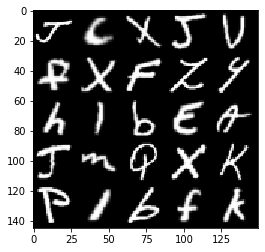

In [ ]:
print('Visualizing Data ...')
rand_indices = np.random.choice(m, 25)
displayData(X_train[rand_indices])
plt.show(block=False)

### **Training the Model Along with Optimization using fmincg**

In [ ]:
print('Training One-vs-All Logistic Regression...\n')

reg_lambda = 0.1
all_theta = oneVsAll(X_train, Y_train, num_labels, reg_lambda)

Training One-vs-All Logistic Regression...

Optimizing theta  0
Optimizing theta  1
Optimizing theta  2
Optimizing theta  3
Optimizing theta  4
Optimizing theta  5
Optimizing theta  6
Optimizing theta  7
Optimizing theta  8
Optimizing theta  9
Optimizing theta  10
Optimizing theta  11
Optimizing theta  12
Optimizing theta  13
Optimizing theta  14
Optimizing theta  15
Optimizing theta  16
Optimizing theta  17
Optimizing theta  18
Optimizing theta  19
Optimizing theta  20
Optimizing theta  22
Optimizing theta  23
Optimizing theta  24
Optimizing theta  25


### **Pre-processing Test Data**

In [ ]:
print('Loading Data ...\n')
X=df_test.drop([0], axis=1)
X_test=X.to_numpy().astype('int')
mt,nt=X_test.shape
Y_test=df_test[0].to_numpy().astype('int').reshape(mt,1)
mt1,nt1=Y_test.shape
print(X_test,'\nShape -', mt, nt,'\n')
print(Y_test, '\nShape -', mt1, nt1)
Y_test = np.where(Y_test == 26, 0, Y_test) #Label of Z is 0 now instead of 26

Loading Data ...

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 
Shape - 14800 784 

[[ 1]
 [ 1]
 [ 1]
 ...
 [19]
 [19]
 [19]] 
Shape - 14800 1


### **Making Predictions on the Test Data**

[ 6  3  2  9 18  3  9 13  3  7  1 16 17 17  2  7 12 10  2  3 10 19  5  5
  7 12 13  4 16 19  5  7  1 15  3 17  4  3 12  6 14 11  3 13 10  4  8  9
  8 12 12  4 18 14 14  1  6 18  3  3 11 16 10 16]
training Set Accuracy::  68.58108108108108 %

Displaying Example Image

(1, 784)


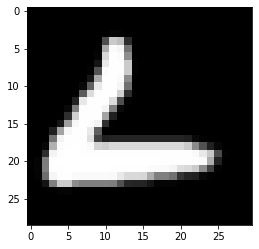


One-vs-all classification for the handwritten Letter dataset prediction:  L
Paused - press enter to continue, q to exit:

Displaying Example Image

(1, 784)


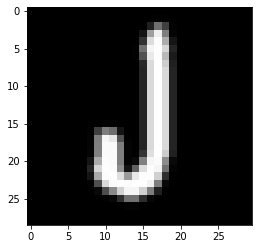


One-vs-all classification for the handwritten Letter dataset prediction:  J
Paused - press enter to continue, q to exit:

Displaying Example Image

(1, 784)


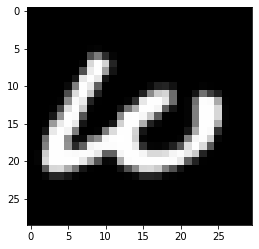


One-vs-all classification for the handwritten Letter dataset prediction:  M
Paused - press enter to continue, q to exit:

Displaying Example Image

(1, 784)


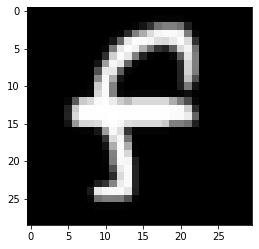


One-vs-all classification for the handwritten Letter dataset prediction:  F
Paused - press enter to continue, q to exit:

Displaying Example Image

(1, 784)


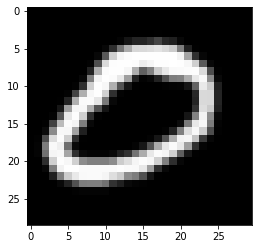


One-vs-all classification for the handwritten Letter dataset prediction:  O
Paused - press enter to continue, q to exit:


In [ ]:
p = predictOneVsAll(all_theta, X_test)
y = Y_test.reshape((mt))

rand_indices2 = np.random.choice(mt, 64)
print(y[rand_indices2])
Y_comp=pd.DataFrame(p, columns=['Predicted'])
print("training Set Accuracy:: ", np.multiply(np.mean((p == y).astype(int)), 100), '%')

rand_indices3 = np.random.choice(mt, 5)

for i in range(5):
  # Display 
  print('\nDisplaying Example Image\n')
  imageData = X_train[rand_indices3[i]].reshape(784, 1).T
  displayData(imageData)
  plt.show(block=False)
  pred = predictOneVsAll(all_theta, imageData)
  if(pred==0):
    predLtr='Z'
  else:
    predLtr=chr(64+pred)
  print('\nOne-vs-all classification for the handwritten Letter dataset prediction: ', predLtr)

  # Pause with quit option
  s = input('Paused - press enter to continue, q to exit:')
  if s == 'q':
    break